# Calculate BT Statistics

Here, we calculate BT histograms for selected regions and times

In [1]:
%matplotlib inline

import numpy as np
import glob

import pylab as pl
import xarray as xr
import datetime

In [2]:
import nawdex_analysis.analysis.averaging
import nawdex_analysis.io.tools


from tropy.standard_config import local_data_path
from tropy.l15_msevi.msevi import MSevi

import tropy.analysis_tools.grid_and_interpolation as gi

## Make a Function for Averaging

In [3]:

def calculate_bthist( dset, itime, btbins = None, 
                     **kwargs ):
       
    '''
    Calculate Cloud-radiative effect (CRE) for different cloud types.

    
    Parameters
    ----------
    dset : xarray Dataset
        set containing CT and mask & area information

    itime : int
       time index of data fields ('swf_net' and 'lwf') in radname

    factor : float
       factor used to convert direction conversion (outward vs. inward)

    filepart : str, optional, default = '-scaled'
       part in the file that gives information about scaling of clear-sky fields
       either '-scaled' or '-not_scaled'


    Returns
    --------
    outset : xarray Dataset
       dataset containing average longwave, short-wave CRE and area fractions
       depending on cloud type
    '''

    
    # prepare analysis array
    m = dset['mask'].data

    bt_field = dset['bt108'].isel( time = itime ).data
    time = dset['time'].isel( time = itime )

    bt = bt_field[m]

    
    
    # calculate area-weighted CRE average
    if btbins is None:
        btbins =  np.linspace(270, 310, 40)
        

    h, xe = np.histogram(bt, btbins)
    
    bin_mids = gi.lmean( xe )
    
    outset = xr.Dataset({
                    'bin_edges' : ('bin_edges', xe, {'longname' : 'bt108 bin edges', 'units':'K'}),
                    'bin_mids'  : ('bin_mids',  bin_mids, {'longname' : 'bt108 bin mid points', 
                                                           'description' : 'arithmetic mean', 'units':'K'}),
                    'time' : ('time', [time.data,], {}),
                    'counts' : (('time','bin_mids'), np.array( [h,] ), 
                                  {'units' : '', 'longname':'absolute counts of bt108'})})

    return outset


## BT Data Input

### Make a Fileist

In [29]:
# version = 'v2019-10-18'
version = 'v2020-02-13'


In [30]:
# old path
fdir = '%s/icon/hdcp2_atlantic_stochconv_main_experiments' % local_data_path

In [31]:
# new path
fdir = '%s/icon/stoch_exp_%s' % ( local_data_path, version )

In [32]:
flist = glob.glob( '%s/[ms]*-hdcp2_atlantic*[!0]??.nc' % fdir)
print( len(flist ))
print(flist)

5
['/vols/fs1/store/senf/data/icon/stoch_exp_v2020-02-13/synsat-hdcp2_atlantic_stochconv_noconvprec_notundepth.nc', '/vols/fs1/store/senf/data/icon/stoch_exp_v2020-02-13/synsat-hdcp2_atlantic_detconv.nc', '/vols/fs1/store/senf/data/icon/stoch_exp_v2020-02-13/synsat-hdcp2_atlantic_stochconv_vervel_-00.nc', '/vols/fs1/store/senf/data/icon/stoch_exp_v2020-02-13/msevi-hdcp2_atlantic-20131220.nc', '/vols/fs1/store/senf/data/icon/stoch_exp_v2020-02-13/synsat-hdcp2_atlantic_noconv.nc']


In [33]:
i = 0
#i = 1
#i = 2
#i = 3
#i = 4
#i = 5
#i = 6

In [34]:
fname = flist[i]
fname

'/vols/fs1/store/senf/data/icon/stoch_exp_v2020-02-13/synsat-hdcp2_atlantic_stochconv_noconvprec_notundepth.nc'

### Get Mask

In [35]:
def get_mask( lat_low = None, lat_upp = None ):
    
    maskname = '%s/landseamask.nc' % fdir
    lsm = xr.open_dataset( maskname )
    
    if lat_low is not None:
        lsm['lsm'].data[ lsm.lat < lat_low ] = 0

    if lat_upp is not None:
        lsm['lsm'].data[ lsm.lat > lat_upp ] = 0
        
    return lsm

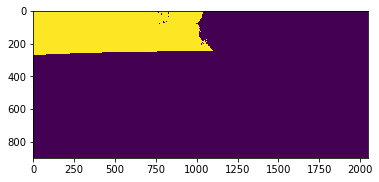

In [36]:
lsm = get_mask(lat_low = 10)
pl.imshow( lsm['lsm'])

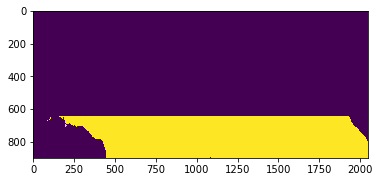

In [37]:
lsm = get_mask(lat_upp = -1)
pl.imshow( lsm['lsm'])

In [38]:
lsm.lat.mean('col').quantile([0.25, 0.5, 0.75])
#

<xarray.DataArray 'lat' (quantile: 3)>
array([-1.888158,  4.335196, 10.645817])
Coordinates:
  * quantile  (quantile) float64 0.25 0.5 0.75

### Open File

In [39]:
def open_btfile( fname, **kwargs ):
    
    dset = xr.open_dataset( fname)
    
    # convert time
    time = nawdex_analysis.io.tools.convert_timevec( dset.time.data )
    dset['time']  = time
    
    # get mask
    lsm = get_mask(**kwargs)
    
    dset['mask'] = lsm['lsm']
    
    return dset

In [40]:
dset = open_btfile( fname )
dset

<xarray.Dataset>
Dimensions:        (col: 2050, cols: 2050, ndim: 2, row: 900, rows: 900, time: 23)
Coordinates:
    lat            (rows, cols) float64 ...
    lon            (rows, cols) float64 ...
  * time           (time) datetime64[ns] 2013-12-20T02:00:00 ... 2013-12-21
Dimensions without coordinates: col, cols, ndim, row, rows
Data variables:
    bt120          (time, rows, cols) float32 ...
    msevi_region   (ndim, ndim) int64 ...
    bt134          (time, rows, cols) float32 ...
    zen            (rows, cols) float64 ...
    nwcsaf_region  (ndim, ndim) int64 ...
    bt087          (time, rows, cols) float32 ...
    bt108          (time, rows, cols) float32 ...
    bt073          (time, rows, cols) float32 ...
    bt062          (time, rows, cols) float32 ...
    mask           (row, col) bool ...
Attributes:
    description:  Synthetic Infrared MSG-SEVIRI images from the Prime Service
    title:        Synthetic MSG-SEVIRI Brightness Temperatures
    institution:  Leibniz In

## Run Calculations

In [41]:
def calc_bthists( dset, btbins = None ):
    
    ntimes = dset.dims['time']
    
    
    bthists = []
    for i in range( ntimes ):
        bthists +=[ calculate_bthist( dset, i, btbins = btbins ), ]
    bthists = xr.merge( bthists )
    
    return bthists

In [42]:
bthists = calc_bthists( dset )
bthists = bthists.expand_dims('region')
bthists['region'] = ['full', ]
bthists

<xarray.Dataset>
Dimensions:    (bin_edges: 40, bin_mids: 39, region: 1, time: 23)
Coordinates:
  * time       (time) datetime64[ns] 2013-12-20T02:00:00 ... 2013-12-21
  * bin_edges  (bin_edges) float64 270.0 271.0 272.1 273.1 ... 307.9 309.0 310.0
  * bin_mids   (bin_mids) float64 270.5 271.5 272.6 273.6 ... 307.4 308.5 309.5
  * region     (region) |S4 'full'
Data variables:
    counts     (region, time, bin_mids) float64 1.513e+04 1.826e+04 ... 0.0 0.0

In [43]:

oname = fname.replace('%s/' % version, '%s/bt-hists_' % version)
oname
#afrac.to_netcdf( oname )


'/vols/fs1/store/senf/data/icon/stoch_exp_v2020-02-13/bt-hists_synsat-hdcp2_atlantic_stochconv_noconvprec_notundepth.nc'

In [44]:
flist

['/vols/fs1/store/senf/data/icon/stoch_exp_v2020-02-13/synsat-hdcp2_atlantic_stochconv_noconvprec_notundepth.nc',
 '/vols/fs1/store/senf/data/icon/stoch_exp_v2020-02-13/synsat-hdcp2_atlantic_detconv.nc',
 '/vols/fs1/store/senf/data/icon/stoch_exp_v2020-02-13/synsat-hdcp2_atlantic_stochconv_vervel_-00.nc',
 '/vols/fs1/store/senf/data/icon/stoch_exp_v2020-02-13/msevi-hdcp2_atlantic-20131220.nc',
 '/vols/fs1/store/senf/data/icon/stoch_exp_v2020-02-13/synsat-hdcp2_atlantic_noconv.nc']

## Full Analysis

In [45]:
def get_bthists4region( fname, regname, **kwargs ):
    
    dset = open_btfile( fname, **kwargs )
    bthists = calc_bthists( dset, btbins =  np.linspace(200, 310, 100) )
    bthists = bthists.expand_dims('region')
    bthists['region'] = [regname, ]
    
    return bthists

In [46]:
def run_full_analysis( fname, version = 'v2019-10-18' ):
    
    # full region
    dset_full = get_bthists4region( fname, 'Full', )
    dset_N = get_bthists4region( fname, 'Northern_Subtropics', lat_low = 10)
    dset_S = get_bthists4region( fname, 'Southern_Subtropics', lat_upp = -1.)
    
    # combine
    dset = xr.merge( [dset_full, dset_N, dset_S] )

    # output
    oname = fname.replace('%s/' % version, '%s/bt-hists_' % version)

    print('... save data to %s' % oname )
    dset.to_netcdf( oname )

    return dset

In [47]:
for fname in flist :
    run_full_analysis( fname, version = version )

... save data to /vols/fs1/store/senf/data/icon/stoch_exp_v2020-02-13/bt-hists_synsat-hdcp2_atlantic_stochconv_noconvprec_notundepth.nc
... save data to /vols/fs1/store/senf/data/icon/stoch_exp_v2020-02-13/bt-hists_synsat-hdcp2_atlantic_detconv.nc
... save data to /vols/fs1/store/senf/data/icon/stoch_exp_v2020-02-13/bt-hists_synsat-hdcp2_atlantic_stochconv_vervel_-00.nc
... save data to /vols/fs1/store/senf/data/icon/stoch_exp_v2020-02-13/bt-hists_msevi-hdcp2_atlantic-20131220.nc
... save data to /vols/fs1/store/senf/data/icon/stoch_exp_v2020-02-13/bt-hists_synsat-hdcp2_atlantic_noconv.nc
